In [1]:
import pandas as pd
import numpy as np

# === Tahap 1: Load Data ===
def load_data():
    data_optimasi = pd.read_csv('C:/Users/User/Documents/SKRIPSI/OPTIMASI PER PENYAKIT/Start_10,10/hasil_optimasi.csv')
    data_rekam = pd.read_csv('C:/Users/User/Documents/SKRIPSI/OPTIMASI PER PENYAKIT/Start_10,10/data_rekam_medis.csv')
    return data_optimasi, data_rekam

# === Tahap 2: Fungsi Kombinasi CF ===
def kombinasi_cf(cf_list):
    if not cf_list:
        return 0
    combined = cf_list[0]
    for cf in cf_list[1:]:
        combined = combined + cf * (1 - combined)
    return combined

# === Tahap 3: Buat Dictionary CF ===
def buat_lookup_cf(data_optimasi):
    cf_pakar = {(row['kode_penyakit'], row['kode_gejala']): row['cf_pakar']
                for _, row in data_optimasi.iterrows()}
    cf_optimasi = {(row['kode_penyakit'], row['kode_gejala']): row['cf_optimasi']
              for _, row in data_optimasi.iterrows()}
    return cf_pakar, cf_optimasi

# === Tahap 4: Hitung CF per pasien ===
def hitung_cf_pasien(group, penyakit_list, cf_dict):
    gejala_pasien = group['kode_gejala'].tolist()
    cf_user_pasien = group['cf_user'].tolist()

    hasil_cf = {}
    for penyakit in penyakit_list:
        cf_list = []
        for gejala, cf_user in zip(gejala_pasien, cf_user_pasien):
            nilai_cf = cf_dict.get((penyakit, gejala))
            if nilai_cf is not None:
                cf_list.append(cf_user * nilai_cf)
        hasil_cf[penyakit] = kombinasi_cf(cf_list)
    return hasil_cf

# === Tahap 5: Proses Utama ===
def proses_diagnosis(data_optimasi, data_rekam):
    cf_pakar_dict, cf_optimasi_dict = buat_lookup_cf(data_optimasi)
    penyakit_list = data_optimasi['kode_penyakit'].unique()

    hasil = []

    for kode_pasien, group in data_rekam.groupby('kode_pasien'):
        diagnosis_asli = group['diagnosis'].iloc[0]

        cf_sebelum = hitung_cf_pasien(group, penyakit_list, cf_pakar_dict)
        cf_setelah = hitung_cf_pasien(group, penyakit_list, cf_optimasi_dict)

        diag_sebelum = max(cf_sebelum.items(), key=lambda x: x[1])
        diag_setelah = max(cf_setelah.items(), key=lambda x: x[1])

        hasil.append({
            'kode_pasien': kode_pasien,
            'diagnosis_asli': diagnosis_asli,
            'diagnosis_sebelum': diag_sebelum[0],
            'cf_sebelum': diag_sebelum[1],
            'cocok_sebelum': diag_sebelum[0] == diagnosis_asli,
            'diagnosis_setelah': diag_setelah[0],
            'cf_setelah': diag_setelah[1],
            'cocok_setelah': diag_setelah[0] == diagnosis_asli
        })

    return pd.DataFrame(hasil)

        # === Tahap 6: Evaluasi Hasil CF ===
def evaluasi_cf(cf_sebelum, cf_setelah):
    if cf_setelah > cf_sebelum:
        return 'lebih_unggul'
    elif cf_setelah == cf_sebelum:
        return 'sama'
    else:
        return 'belum_teroptimasi'

def evaluasi_hasil(hasil_df):
    hasil_df['cf_lebih_unggul'] = hasil_df.apply(
        lambda row: evaluasi_cf(row['cf_sebelum'], row['cf_setelah']),
        axis=1
    )
    return hasil_df




# === Main ===
if __name__ == "__main__":
    data_optimasi, data_rekam = load_data()
    hasil_df = proses_diagnosis(data_optimasi, data_rekam)
    hasil_df = evaluasi_hasil(hasil_df)

    print(hasil_df)
    hasil_df.to_csv('hasil_perbandingan_diagnosis_FIX.csv', index=False)


   kode_pasien diagnosis_asli diagnosis_sebelum  cf_sebelum  cocok_sebelum  \
0        PAS01            P03               P06    0.978227          False   
1        PAS02            P03               P07    0.951040          False   
2        PAS03            P02               P02    0.962560           True   
3        PAS04            P04               P04    0.891136           True   
4        PAS05            P06               P07    0.990208          False   
..         ...            ...               ...         ...            ...   
95       PAS95            P03               P06    0.966400          False   
96       PAS96            P06               P06    0.985600           True   
97       PAS97            P06               P06    0.997120           True   
98       PAS98            P04               P04    0.928000           True   
99       PAS99            P06               P06    0.987904           True   

   diagnosis_setelah  cf_setelah  cocok_setelah    cf_lebih_ung

In [2]:
# Statistik cocok_sebelum dan cocok_setelah

# Hitung total pasien
total_pasien = len(hasil_df)

# Hitung pasien cocok sebelum dan sesudah
jumlah_cocok_sebelum = hasil_df['cocok_sebelum'].sum()
jumlah_cocok_setelah = hasil_df['cocok_setelah'].sum()

# Hitung persentasenya
persen_cocok_sebelum = (jumlah_cocok_sebelum / total_pasien) * 100
persen_cocok_setelah = (jumlah_cocok_setelah / total_pasien) * 100

# Tampilkan hasil
print("Total Pasien:", total_pasien)
print("cocok Sebelum Optimasi: {} pasien ({:.2f}%)".format(jumlah_cocok_sebelum, persen_cocok_sebelum))
print("cocok Sesudah Optimasi: {} pasien ({:.2f}%)".format(jumlah_cocok_setelah, persen_cocok_setelah))


Total Pasien: 100
cocok Sebelum Optimasi: 85 pasien (85.00%)
cocok Sesudah Optimasi: 88 pasien (88.00%)


In [3]:
# Pasien yang cocok baik sebelum maupun sesudah optimasi
mask_sama_cocok = (hasil_df['cocok_sebelum'] == True) & (hasil_df['cocok_setelah'] == True)
jumlah_sama_cocok = mask_sama_cocok.sum()

print("Jumlah pasien dengan diagnosis yang cocok di SEBELUM dan SESUDAH optimasi:", jumlah_sama_cocok)


Jumlah pasien dengan diagnosis yang cocok di SEBELUM dan SESUDAH optimasi: 82


In [4]:
# Filter hanya pasien yang diagnosisnya cocok sebelum dan sesudah
df_sama_cocok = hasil_df[mask_sama_cocok]

# Hitung statistik evaluasi nilai CF
jumlah_lebih_unggul = (df_sama_cocok['cf_lebih_unggul'] == 'lebih_unggul').sum()
jumlah_sama = (df_sama_cocok['cf_lebih_unggul'] == 'sama').sum()
jumlah_belum = (df_sama_cocok['cf_lebih_unggul'] == 'belum_teroptimasi').sum()

print("Total pasien dengan diagnosis yang cocok di sebelum dan sesudah optimasi:", len(df_sama_cocok))
print("Pasien dengan nilai CF lebih unggul setelah optimasi:", jumlah_lebih_unggul)
print("Pasien dengan nilai CF tetap:", jumlah_sama)
print("Pasien yang belum teroptimasi:", jumlah_belum)




Total pasien dengan diagnosis yang cocok di sebelum dan sesudah optimasi: 82
Pasien dengan nilai CF lebih unggul setelah optimasi: 58
Pasien dengan nilai CF tetap: 2
Pasien yang belum teroptimasi: 22


In [5]:
total_pasien = len(hasil_df)
persen_cf_naik = (jumlah_lebih_unggul / jumlah_sama_cocok) * 100

print("Persentase pasien dengan kenaikan nilai CF dari pasien yang sama-sama cocok :", round(persen_cf_naik, 2), "%")


Persentase pasien dengan kenaikan nilai CF dari pasien yang sama-sama cocok : 70.73 %


D:\BELAJAR\MIINICONDA\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\BELAJAR\MIINICONDA\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\BELAJAR\MIINICONDA\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\BELAJAR\MIINICONDA\lib\site-packages\sklearn\metrics\_classification.p

== Classification Report SEBELUM OPTIMASI ==
              precision    recall  f1-score   support

         P01       1.00      1.00      1.00         1
         P02       0.96      0.96      0.96        26
         P03       1.00      0.59      0.74        17
         P04       1.00      1.00      1.00        16
         P05       0.00      0.00      0.00         0
         P06       0.72      0.84      0.78        25
         P07       0.00      0.00      0.00         0
         P08       1.00      0.80      0.89        15

    accuracy                           0.85       100
   macro avg       0.71      0.65      0.67       100
weighted avg       0.92      0.85      0.87       100


== Classification Report SESUDAH OPTIMASI ==
              precision    recall  f1-score   support

         P01       1.00      1.00      1.00         1
         P02       0.96      0.92      0.94        26
         P03       0.80      0.71      0.75        17
         P04       1.00      0.94      0.

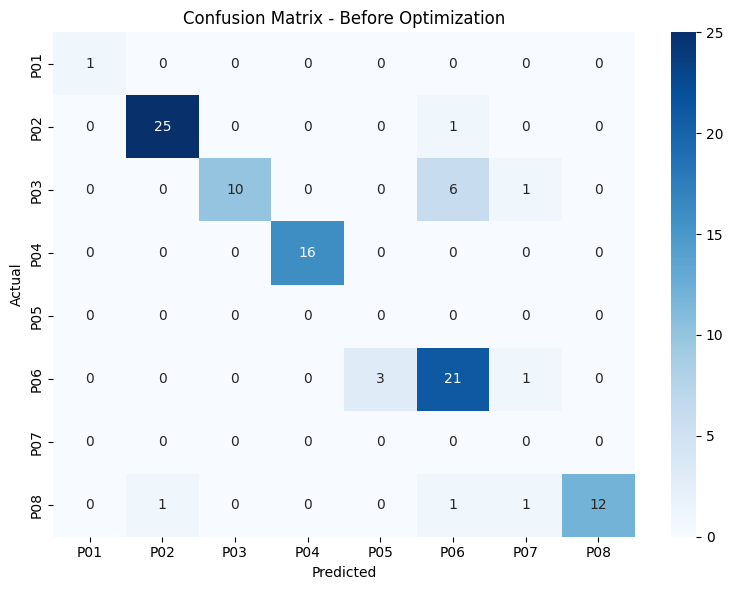

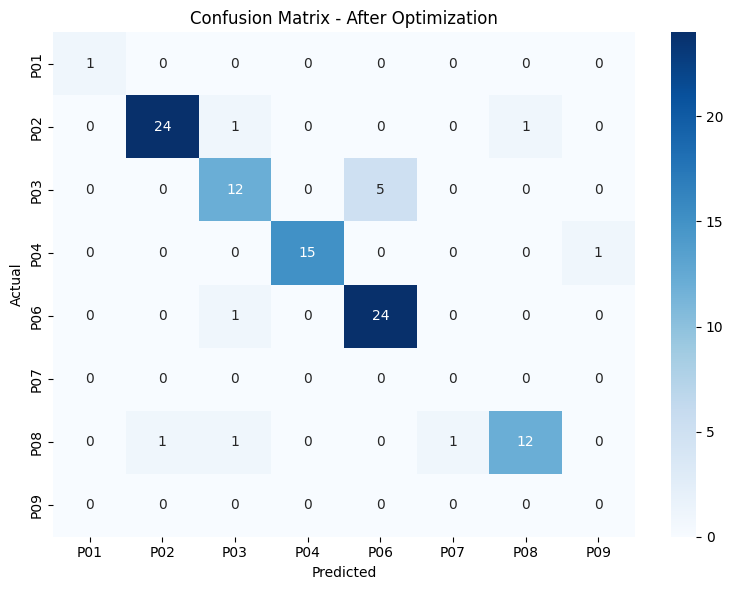

In [6]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# === LOAD DATA HASIL DIAGNOSIS ===
hasil_df = pd.read_csv('hasil_perbandingan_diagnosis_FIX.csv')

# === FUNGSI EVALUASI ===
def evaluasi_metrik(hasil_df, label='sebelum'):
    y_true = hasil_df['diagnosis_asli']
    y_pred = hasil_df[f'diagnosis_{label}']

    labels = sorted(list(set(y_true) | set(y_pred)))  # ambil semua label unik
    matrix = confusion_matrix(y_true, y_pred, labels=labels)
    report = classification_report(y_true, y_pred, labels=labels, output_dict=True)

    return labels, matrix, report

# === HITUNG METRIK SEBELUM & SESUDAH OPTIMASI ===
labels_sblm, cm_sblm, report_sblm = evaluasi_metrik(hasil_df, 'sebelum')
labels_stlh, cm_stlh, report_stlh = evaluasi_metrik(hasil_df, 'setelah')

# === CETAK HASIL TEXTUAL ===
print("== Classification Report SEBELUM OPTIMASI ==")
print(classification_report(hasil_df['diagnosis_asli'], hasil_df['diagnosis_sebelum']))

print("\n== Classification Report SESUDAH OPTIMASI ==")
print(classification_report(hasil_df['diagnosis_asli'], hasil_df['diagnosis_setelah']))

# === VISUALISASI CONFUSION MATRIX ===
def plot_confusion_matrix(cm, labels, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm_sblm, labels_sblm, "Confusion Matrix - Before Optimization")
plot_confusion_matrix(cm_stlh, labels_stlh, "Confusion Matrix - After Optimization")
